# Clickbait News Detection
## Semi-supervised and transfer learning approaches to NLP, namely, to Text Classification

We are provided with labeled articles. Each article consists of label and body. The task is to predict the label (clickbait, news or other).<br>
With EDA we get insights to our dataset. We use Text Processing for this NLP project and visualize most frequent words in wordcloud. In the end we peform a Sentiment Analysis using TextBlob.

For more information about the dataset use the following Kaggle link:<br>
https://www.kaggle.com/competitions/clickbait-news-detection/data

## Import libraries and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import nltk
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/silhouette/click.png
/kaggle/input/silhouette/news.png
/kaggle/input/silhouette/cloud.png
/kaggle/input/silhouettes/news.jpeg
/kaggle/input/clickbait-news-detection/unlabeled.csv
/kaggle/input/clickbait-news-detection/sample_submission.csv
/kaggle/input/clickbait-news-detection/valid.csv
/kaggle/input/clickbait-news-detection/train.csv
/kaggle/input/clickbait-news-detection/test.csv


## EDA - Exploratory Data Analysis

In [2]:
# load data, remove index column and rename label column to class
df = pd.read_csv('/kaggle/input/clickbait-news-detection/train.csv', skiprows=1, names=['title','text','class'])
df.head() # first 5 entries

,title,text,class
0,China and Economic Reform: Xi Jinping’s Track ...,Economists generally agree: China must overhau...,news
1,Trade to Be a Big Topic in Theresa May’s U.S. ...,LONDON—British Prime Minister Theresa May said...,news
2,"The Top Beaches In The World, According To Nat...",Beaches come in all sorts of shapes and sizes ...,clickbait
3,Sheriff’s Report Provides New Details on Tamir...,"A timeline of what happened after Tamir Rice, ...",clickbait
4,Surgeon claiming he will transplant volunteer'...,An Italian neurosurgeon who has claimed for mo...,news


In [3]:
# with dictionary map all classes numbers
df["label"]=df["class"].map({"news":0,"clickbait":1,"other":2})
df.head() # lets see new dataframes first 5 entries

,title,text,class,label
0,China and Economic Reform: Xi Jinping’s Track ...,Economists generally agree: China must overhau...,news,0
1,Trade to Be a Big Topic in Theresa May’s U.S. ...,LONDON—British Prime Minister Theresa May said...,news,0
2,"The Top Beaches In The World, According To Nat...",Beaches come in all sorts of shapes and sizes ...,clickbait,1
3,Sheriff’s Report Provides New Details on Tamir...,"A timeline of what happened after Tamir Rice, ...",clickbait,1
4,Surgeon claiming he will transplant volunteer'...,An Italian neurosurgeon who has claimed for mo...,news,0


In [4]:
df.info() # infos about the samples, features and datatypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24871 entries, 0 to 24870
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   19947 non-null  object
 1   text    24788 non-null  object
 2   class   24871 non-null  object
 3   label   24871 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 971.5+ KB


In [5]:
df.isnull().sum() # checking for missing values

title    4924
text       83
class       0
label       0
dtype: int64

We have a total amount of 24871 samples with 4 features. Since we have some missing values in text and title, we are going to fill them with a stopword, so it doesn't disturb our process.

In [6]:
df.fillna("a", inplace=True) # fill NaN values with a stopword

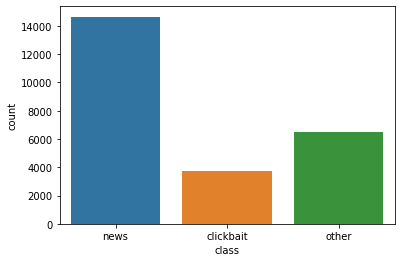

In [7]:
sns.countplot(x=df["class"]); # plot the classes

Most of our texts are news, then of other type and least is clickbait. Let's proceed to text processing, one of the most important tasks in NLP Projects.

In [8]:
# example text before text processing
df.text[0]

'Economists generally agree: China must overhaul its huge but wasteful economy if it wants to continue to grow in the years to come. That means limiting political interference in banking and the financial system, making bloated industries more sensitive to market forces and lowering barriers against foreign trade and investment. Proponents took heart in late 2012 when President Xi Jinping took formal control of the Chinese Communist Party with pledges to crack down on corruption and cut red tape. Today, as Mr. Xi nears the end of his first five-year term, much of the optimism among economists has faded. China remains heavily dependent on large investments and has maintained brisk but slowing economic growth only with a steep rise in government-steered lending. Still, his administration has made some small changes, and there have been hints that Mr. Xi may focus more on economic overhauls when he starts his second term. Here is what Mr. Xi has done so far — and, more important, what he 

## Text Processing in NLP projects:
* Convert all text to lowercase
* Remove punctuation marks
* Remove numbers
* Remove line break and enter \r \n
* Stop words (remove unnecessary words)
* Tokenize the text
* Remmove suffixes with Lemma and Stemma and find roots
* Convert texts to numbers with Vectorize

In [9]:
# Text Processing
df["text"]=df["text"].str.lower() # convert to lowercase
df["text"]=df["text"].str.replace('[^\w\s]','') # remoove punctioation marks
df["text"]=df["text"].str.replace('\d+','') # remove numbers
df["text"]=df["text"].str.replace('\n',' ').replace('\r',' ') # remove line break and enter \r \n

In [11]:
# example text after text processing
df.text[0]

'economists generally agree china must overhaul its huge but wasteful economy if it wants to continue to grow in the years to come that means limiting political interference in banking and the financial system making bloated industries more sensitive to market forces and lowering barriers against foreign trade and investment proponents took heart in late  when president xi jinping took formal control of the chinese communist party with pledges to crack down on corruption and cut red tape today as mr xi nears the end of his first fiveyear term much of the optimism among economists has faded china remains heavily dependent on large investments and has maintained brisk but slowing economic growth only with a steep rise in governmentsteered lending still his administration has made some small changes and there have been hints that mr xi may focus more on economic overhauls when he starts his second term here is what mr xi has done so far  and more important what he has not done reforms exp

## Wordclouds
Wordclouds (WC) allow us the visual representations of the frequency and relative importance of words in a given body of text.<br>
We are going to generate 3 Wordcloud; for news, clickbait and other.

In [61]:
# Function to create a Wordcloud
def wc(data,bgcolor):
    plt.figure(figsize=(10,10))
    mask=np.array(Image.open("/kaggle/input/silhouette/news.png"))
    wc=WordCloud(background_color=bgcolor,stopwords=STOPWORDS,mask=mask) 
    wc.generate(' '.join(data)) 
    plt.imshow(wc) 
    plt.axis("off")

In [13]:
# seperate texts for each class
news=df[df["class"]=="news"]["text"] # only news texts
clickbait=df[df["class"]=="clickbait"]["text"] # # only clickbait texts
other=df[df["class"]=="other"]["text"] # # only other texts

In [14]:
news.shape, clickbait.shape, other.shape # see the shape of the classes

((14650,), (3748,), (6473,))

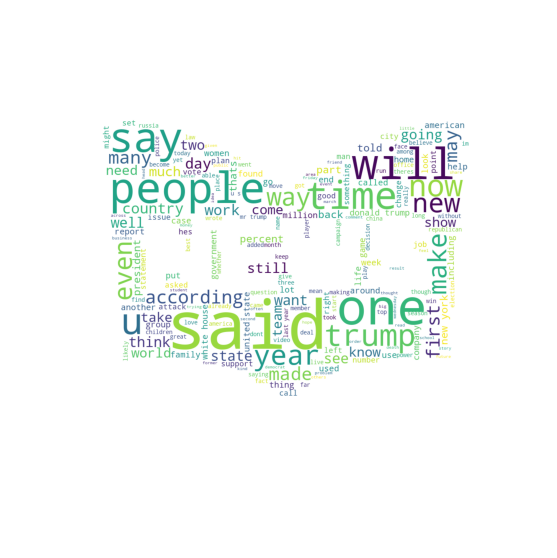

In [62]:
wc(news,'white') # WC for news

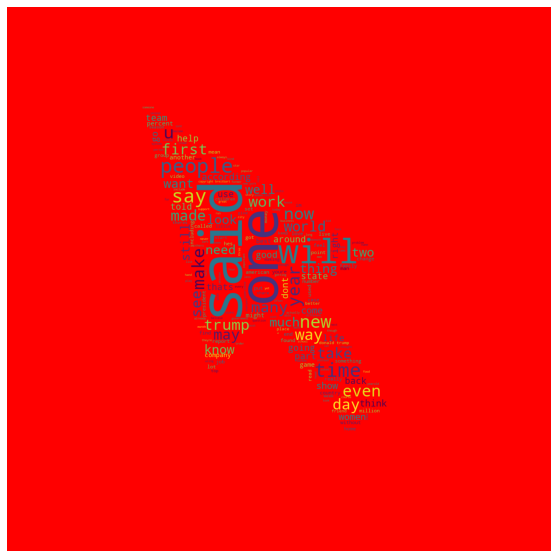

In [58]:
wc(clickbait,'red') # WC for clickabit

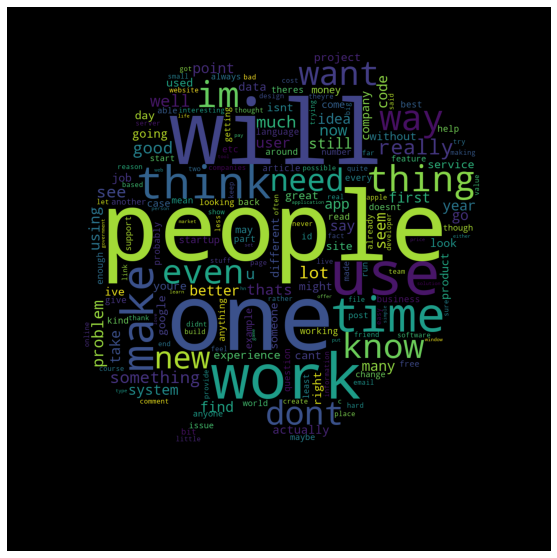

In [60]:
wc(other,'black') # WC for other

It seems to me that all the wordclouds have almost the same words in it, or at least they are very similar.

## Modelling
After assignin our X(features) and y (target), we use a Vectorizer to convert our text documents into a matrix, then we split our data to train and test sets and with various Classifiers we try to train our Model.

In [18]:
# assign x and y - features are texts and target is label
x,y =df["text"], df["label"]

The **CountVectorizer** is a tool from the scikit-learn library that can be used to convert a collection of text documents into a matrix of token counts. 

In [19]:
# Vectorize text data, ignoring stop words
vect=CountVectorizer(stop_words="english")
x=vect.fit_transform(x)
# split to train and test data
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=.15)

In [20]:
#importing Classification libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# create an instance of each classification algorithm
mb=MultinomialNB()
D=DecisionTreeClassifier()
KN=KNeighborsClassifier() 
R=RandomForestClassifier()
XGB=XGBClassifier()

classifiers = [mb, D, KN, R, XGB]

# list of classifier names
classifier_names = ['MultinomialNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'RandomForestClassifier', 'XGBClassifier']

# create an empty dataframe
df = pd.DataFrame(columns=['classifier', 'accuracy'])

# loop through classifiers and get predictions
for i, clf in enumerate(classifiers):
    pred = clf.fit(x_train, y_train).predict(x_test)
    score = accuracy_score(pred, y_test)
    df.loc[i] = [classifier_names[i], score]

In [21]:
# sort the dataframe by the accuracy column in descending order
df.sort_values(by='accuracy', ascending=False, inplace=True)
df

,classifier,accuracy
4,XGBClassifier,0.849638
3,RandomForestClassifier,0.835165
1,DecisionTreeClassifier,0.761994
0,MultinomialNB,0.726883
2,KNeighborsClassifier,0.452694


We can see that the best result shows the **XGBClassifier with an Accuracy of 84,96%,** followed by the RandomForestClassifier with similar accuracy.

## We could also show the titles in a Wordcloud

In [22]:
# load data, remove index column and rename label column to class
df = pd.read_csv('/kaggle/input/clickbait-news-detection/train.csv', skiprows=1, names=['title','text','class'])
df.fillna("a", inplace=True) # fill NaN values with a stopword
df.head() # first 5 entries

,title,text,class
0,China and Economic Reform: Xi Jinping’s Track ...,Economists generally agree: China must overhau...,news
1,Trade to Be a Big Topic in Theresa May’s U.S. ...,LONDON—British Prime Minister Theresa May said...,news
2,"The Top Beaches In The World, According To Nat...",Beaches come in all sorts of shapes and sizes ...,clickbait
3,Sheriff’s Report Provides New Details on Tamir...,"A timeline of what happened after Tamir Rice, ...",clickbait
4,Surgeon claiming he will transplant volunteer'...,An Italian neurosurgeon who has claimed for mo...,news


In [23]:
# Text Processing
df["title"]=df["title"].str.lower() # convert to lowercase
df["title"]=df["title"].str.replace('[^\w\s]','') # remoove punctioation marks
df["title"]=df["title"].str.replace('\d+','') # remove numbers
df["title"]=df["title"].str.replace('\n',' ').replace('\r',' ') # remove line break and enter \r \n

In [24]:
df.title[0] # example title after text processing

'china and economic reform xi jinpings track record '

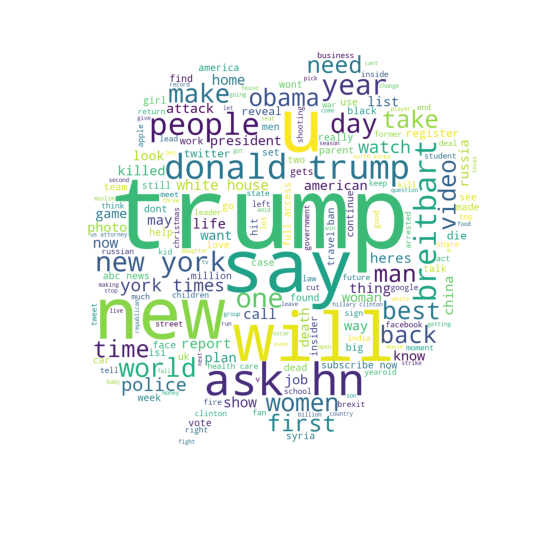

In [25]:
wc(df.title,'white')

Interesting to see that the word with most frequency in the titles include "trump". We can also see words like obama, russia, china and more.

## Sentiment Analysis - Using TextBlob
Sentiment analysis with TextBlob: TextBlob can perform sentiment analysis on a text, which involves determining the overall sentiment expressed in the text (e.g., positive, negative, neutral).

In [26]:
# import TextBlob
from textblob import TextBlob

In [27]:
# function for sentiment analysis
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [30]:
# define new dataframe
df_sent=df[["text"]] 
df_sent.head()

,text
0,Economists generally agree: China must overhau...
1,LONDON—British Prime Minister Theresa May said...
2,Beaches come in all sorts of shapes and sizes ...
3,"A timeline of what happened after Tamir Rice, ..."
4,An Italian neurosurgeon who has claimed for mo...


In [32]:
# call sentiment function on our text and create new column with values
df_sent["sentiment"]=df_sent["text"].apply(detect_sentiment)
df_sent.head()

,text,sentiment
0,Economists generally agree: China must overhau...,0.061450
1,LONDON—British Prime Minister Theresa May said...,0.025000
2,Beaches come in all sorts of shapes and sizes ...,0.037879
3,"A timeline of what happened after Tamir Rice, ...",-0.009724
4,An Italian neurosurgeon who has claimed for mo...,0.066044


In [34]:
df_sent.sentiment.value_counts()

 0.000000    1322
 0.500000     196
 0.250000     147
 0.200000      98
 0.100000      92
             ... 
 0.126380       1
 0.095390       1
 0.107860       1
-0.000694       1
 0.090759       1
Name: sentiment, Length: 19522, dtype: int64

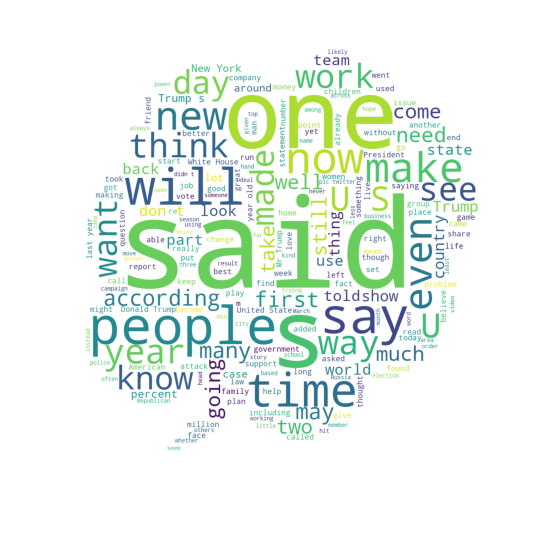

In [35]:
wc(df_sent.text,'white')

### Epsilon Neighborhood
In the context of sentiment analysis, epsilon neighborhoods can be used to identify reviews that express similar sentiments. For example, we might define an epsilon neighborhood around a review that is very positive, and then identify all other reviews that fall within that neighborhood as also being very positive.

In [36]:
# 1 positive
# 2 negative
# 0 neutral
def sentiment2(sent):
    if sent<-0.02: #0.02:limit
        return 2
    elif sent>0.02:
        return 1
    else:
        return 0

In [37]:
# apply new sentiment function 
df_sent["sent"]=df_sent["sentiment"].apply(sentiment2)

In [39]:
df_sent.head()

,text,sentiment,sent
0,Economists generally agree: China must overhau...,0.061450,1
1,LONDON—British Prime Minister Theresa May said...,0.025000,1
2,Beaches come in all sorts of shapes and sizes ...,0.037879,1
3,"A timeline of what happened after Tamir Rice, ...",-0.009724,0
4,An Italian neurosurgeon who has claimed for mo...,0.066044,1


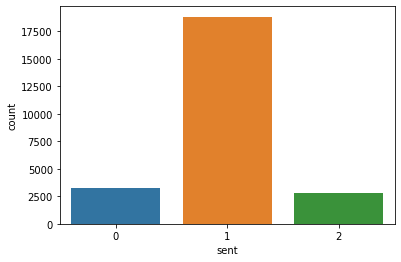

In [41]:
sns.countplot(df_sent.sent); # plot the sentiment analysis

In [43]:
df_sent.sent.value_counts()

1    18837
0     3277
2     2757
Name: sent, dtype: int64

We have 18837 positive, 2757 negative and 3277 neutral comments

## Modeling - Sentiment Analysis

In [45]:
# assign x and y
x, y=df_sent.text, df_sent.sent

In [46]:
# Vectorize X
vect=CountVectorizer(stop_words="english")
x=vect.fit_transform(x) 

In [47]:
# split into train and test sets
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=.15)

In [48]:
#importing Classification libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# create an instance of each classification algorithm
mb=MultinomialNB()
D=DecisionTreeClassifier()
KN=KNeighborsClassifier() 
R=RandomForestClassifier()
XGB=XGBClassifier()

classifiers = [mb, D, KN, R, XGB]

# list of classifier names
classifier_names = ['MultinomialNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'RandomForestClassifier', 'XGBClassifier']

# create an empty dataframe
df2 = pd.DataFrame(columns=['classifier', 'accuracy'])

# loop through classifiers and get predictions
for i, clf in enumerate(classifiers):
    pred = clf.fit(x_train, y_train).predict(x_test)
    score = accuracy_score(pred, y_test)
    df2.loc[i] = [classifier_names[i], score]

In [49]:
# sort the dataframe by the accuracy column in descending order
df2.sort_values(by='accuracy', ascending=False, inplace=True)
df2

,classifier,accuracy
3,RandomForestClassifier,0.792817
4,XGBClassifier,0.783168
0,MultinomialNB,0.730367
1,DecisionTreeClassifier,0.730099
2,KNeighborsClassifier,0.530957


Afters using TextBlobs Sentiment function the best results are from the **RandomForestClassifier with an Accuracy of 79,28%.**

In [50]:
positive=df_sent[df_sent["sent"]==1]["text"] # only positive
neutral=df_sent[df_sent["sent"]==0]["text"] # only neutral
negative=df_sent[df_sent["sent"]==2]["text"] # only negative

### Wordclouds for Sentiment Analysis

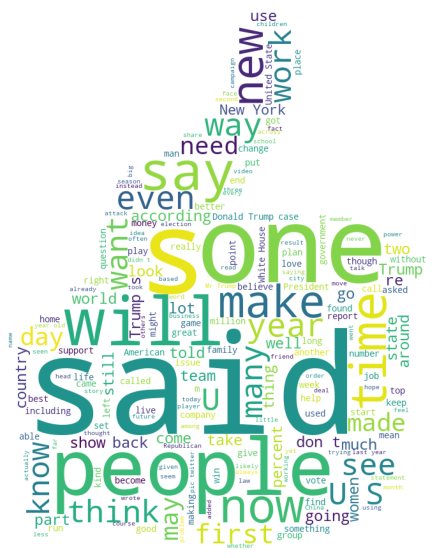

In [52]:
wc(positive,'white') # WC for positive sentiment analysis

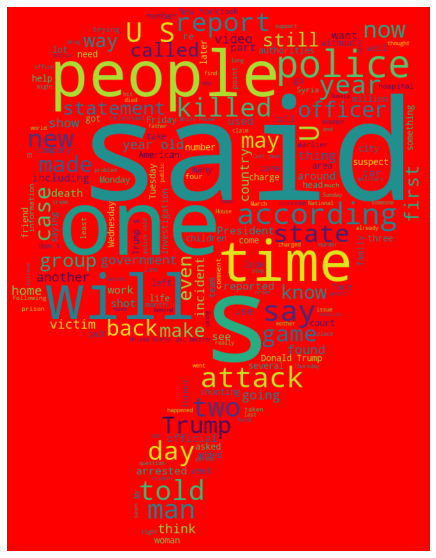

In [54]:
wc(negative,'red') # WC for negative sentiment analysis

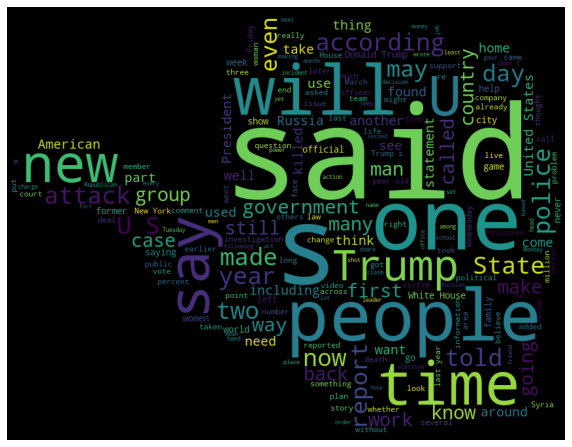

In [56]:
wc(neutral,'black') # WC for neutral sentiment analysis